File: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Counts/output_csvs/Counts_BS26194A, Total Reads: 374696.0, Normalization Value: 0.000267
Figure saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Heatmaps/Counts_BS26194A_heatmap.svg


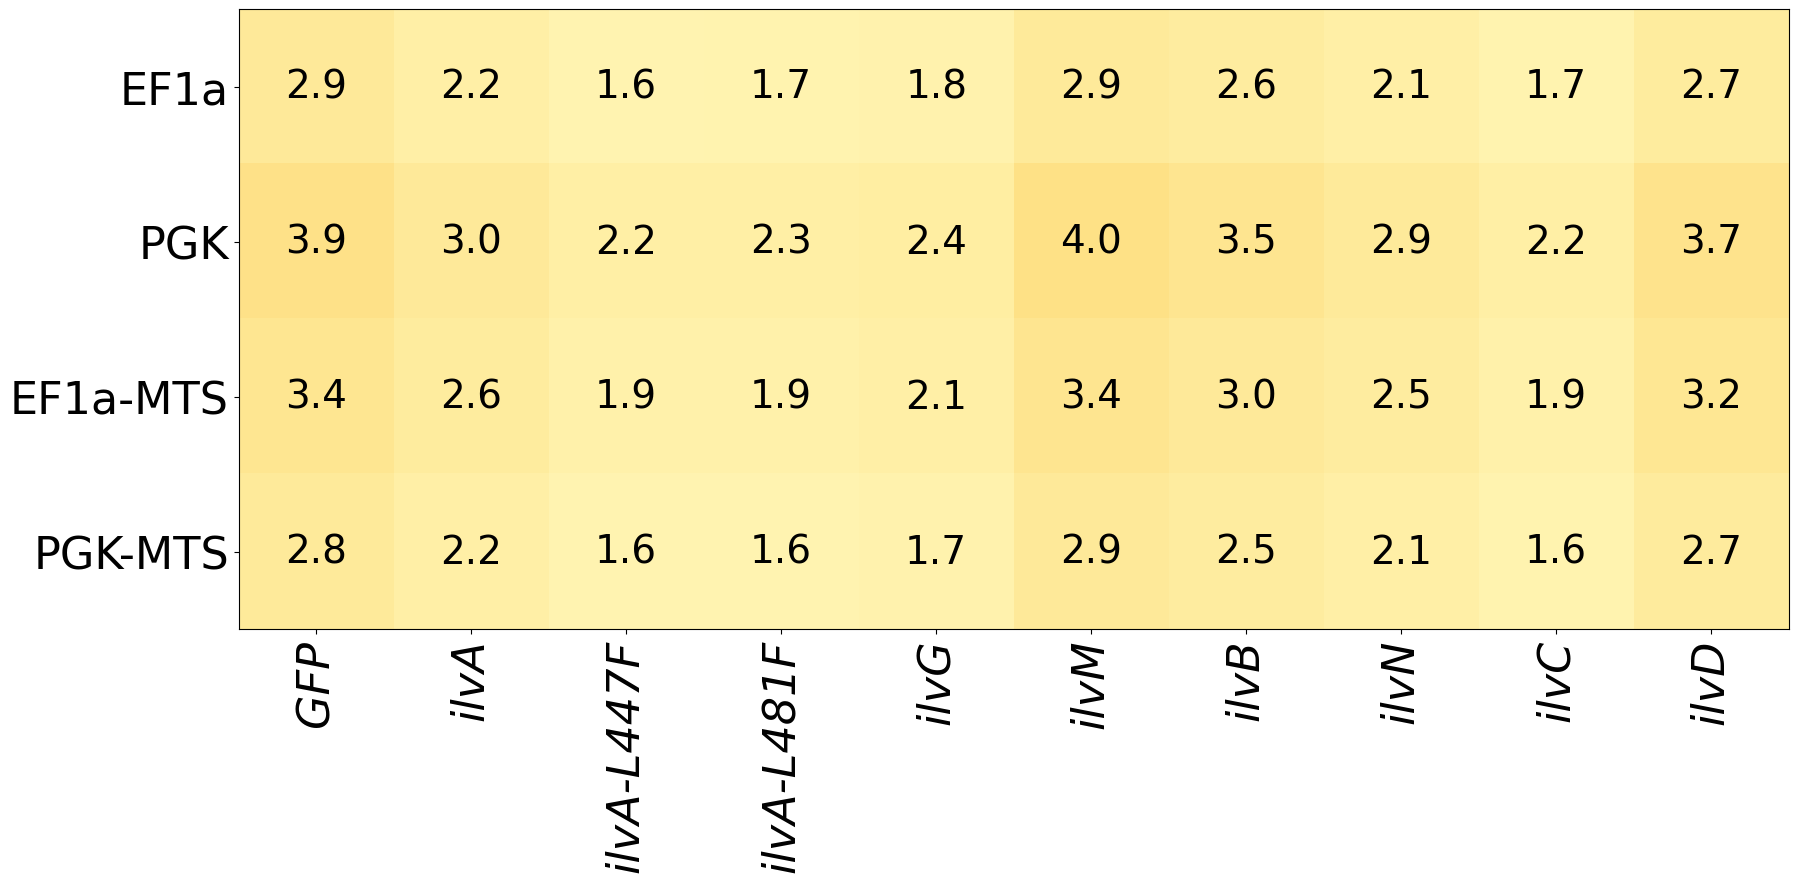

File: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Counts/output_csvs/Counts_BS28194A, Total Reads: 270465.0, Normalization Value: 0.000370
Figure saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Heatmaps/Counts_BS28194A_heatmap.svg


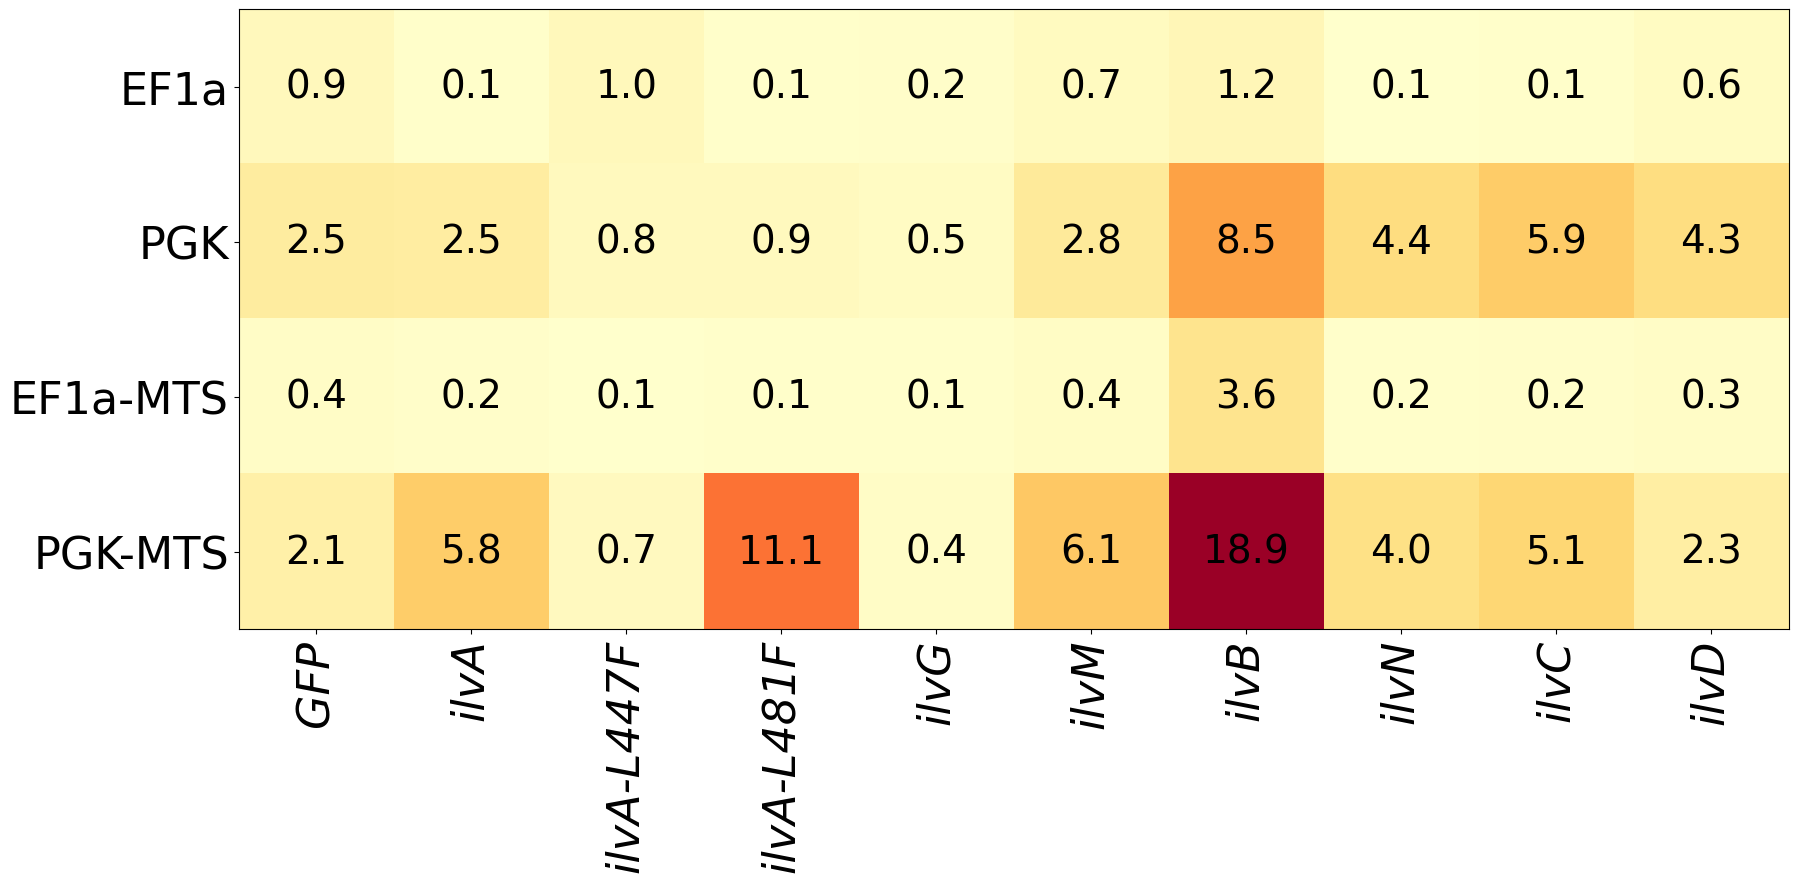

File: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Counts/output_csvs/Counts_BS28195A, Total Reads: 161957.0, Normalization Value: 0.000617
Figure saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Heatmaps/Counts_BS28195A_heatmap.svg


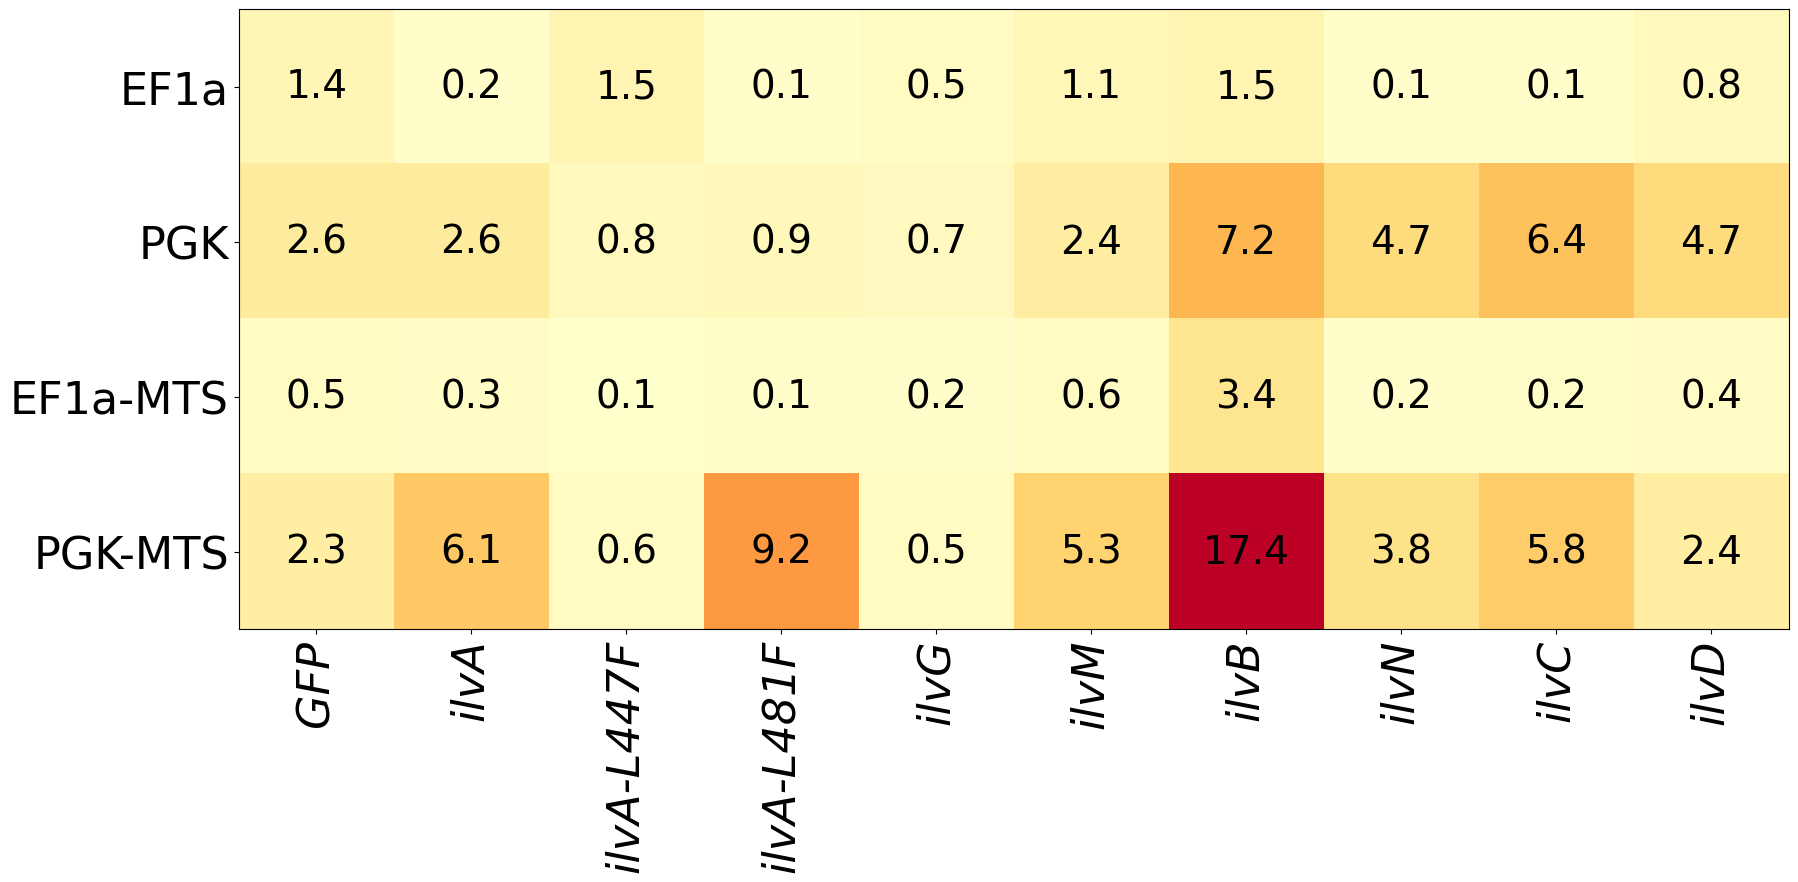

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from matplotlib.colors import LinearSegmentedColormap

# Set paths
input_dir = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Counts/output_csvs'
output_folder = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Controls/Controls_Heatmaps'
os.makedirs(output_folder, exist_ok=True)

# Discover input files
input_files = sorted(glob.glob(os.path.join(input_dir, 'Counts_BS*')))

# Define promoters and CDS
promoters = ['Ef1a', 'PGK']
mts_promoters = [f'{p}-MTS' for p in promoters]
cds = ['GFP', 'ilvA', 'ilvA mut 1', 'ilvA mut 2', 'ilvG', 'ilvM', 'ilvB', 'ilvN', 'ilvC', 'ilvD']

# Loop through each file
for file_path in input_files:
    df = pd.read_csv(file_path, skiprows=13, names=['BC Number', 'BC Name', 'Sequence', 'Counts'])

    total_reads = df['Counts'].sum()
    normalization_value = 100 / total_reads
    print(f"File: {file_path}, Total Reads: {total_reads}, Normalization Value: {normalization_value:.6f}")

    # Filter usable rows
    df_filtered = df[
        (~df['BC Name'].str.contains("Unassigned")) &
        (df['BC Name'].str.contains("Ef1a__|PGK__|CMV__|TightTRE__|NoProm__|Ef1a-MTS__|PGK-MTS__|CMV-MTS__|TightTRE-MTS__|NoProm-MTS__|__Ef1a|__PGK|__CMV|__TightTRE|__NoProm"))
    ]

    sum_TU = {}

    # Sum non-MTS promoters
    for promoter in promoters:
        for cd in cds:
            fwd = df_filtered['BC Name'].str.contains(f"{cd}__{promoter}(?!-MTS)", regex=True)
            rev = df_filtered['BC Name'].str.contains(f"{promoter}__{cd}(?!-MTS)", regex=True)
            sum_TU[f'{promoter}_{cd}'] = (df_filtered.loc[fwd, 'Counts'].sum() + df_filtered.loc[rev, 'Counts'].sum()) * normalization_value

    # Sum MTS promoters
    for promoter in mts_promoters:
        for cd in cds:
            fwd = df_filtered['BC Name'].str.contains(f"{cd}__{promoter}")
            rev = df_filtered['BC Name'].str.contains(f"{promoter}__{cd}")
            sum_TU[f'{promoter}_{cd}'] = (df_filtered.loc[fwd, 'Counts'].sum() + df_filtered.loc[rev, 'Counts'].sum()) * normalization_value

    # Create heatmap data matrix
    heatmap_data = pd.DataFrame([
        [sum_TU[f'Ef1a_{cd}'] for cd in cds],
        [sum_TU[f'PGK_{cd}'] for cd in cds],
        [sum_TU[f'Ef1a-MTS_{cd}'] for cd in cds],
        [sum_TU[f'PGK-MTS_{cd}'] for cd in cds]
    ])

    # Generate figure
    plt.figure(figsize=(20, 10))
    plt.imshow(heatmap_data, cmap=plt.cm.YlOrRd, interpolation='nearest', vmin=0, vmax=20)

    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            plt.text(j, i, f"{heatmap_data.iloc[i, j]:.1f}", ha='center', va='center', color='black', fontsize=28)

    xtick_labels = ['GFP', 'ilvA', 'ilvA-L447F', 'ilvA-L481F', 'ilvG', 'ilvM', 'ilvB', 'ilvN', 'ilvC', 'ilvD']
    ytick_labels = ['EF1a', 'PGK', 'EF1a-MTS', 'PGK-MTS']

    plt.xticks(np.arange(len(xtick_labels)), xtick_labels, rotation=90, fontsize=32, fontstyle='italic')
    plt.yticks(np.arange(len(ytick_labels)), ytick_labels, fontsize=32)

    output_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(file_path))[0]}_heatmap.svg")
    plt.savefig(output_file, format='svg', dpi=300, bbox_inches='tight')
    print(f"Figure saved as: {output_file}")
    plt.show()
